# fMRI Data Correlation Maps

Importing the libraries for analyzing and visualizing the dataset,

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Enable plots inside the Jupyter Notebook
%matplotlib inline

Loading the .csv data file we created in the previous notebook,

In [3]:
# Import the data for slice 36
data = np.genfromtxt('./fMRI_data/csv_data/slice_36.csv', delimiter=',')

To get the dimensions of the scan right and create our design matrix, we need to read the README.txt file of the dataset.

In [4]:
# These are the main parameters of the fMRI scan and experimental desgin
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

Checking the shape of the data matrix,

In [5]:
print(data.shape)

(4096, 96)


To reshape the data, we need to transform it back to a 3D array. Since we have one slice of the scan loaded the dimensions should be 64x64 voxels with each voxel having 96 timepoints.

In [7]:
data_ordered = data.reshape(x_size, y_size, acq_num)
print(data_ordered.shape)

(64, 64, 96)


Looking at the data, whether we look at the specific volume or average all volumes (timepoints) to find the mean signal intensity, we end up with a 64x64 matrix.

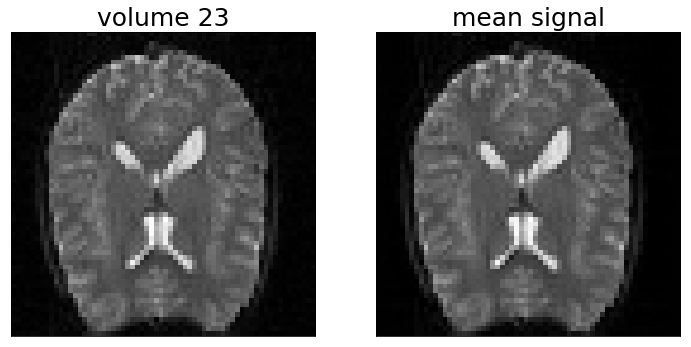

In [9]:
# Average all volumes
mean_data = data_ordered.mean(axis=2)

# Create plots
fig, ax = plt.subplots(1, 2,figsize=(12, 6))

# Plot volume number 23
ax[0].imshow(data_ordered[:, :, 23], cmap='gray')
ax[0].set_title('volume 23', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Plot mean signal intensities
ax[1].imshow(mean_data, cmap='gray')
ax[1].set_title('mean signal', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

To find the time course of a random voxel in this scan,

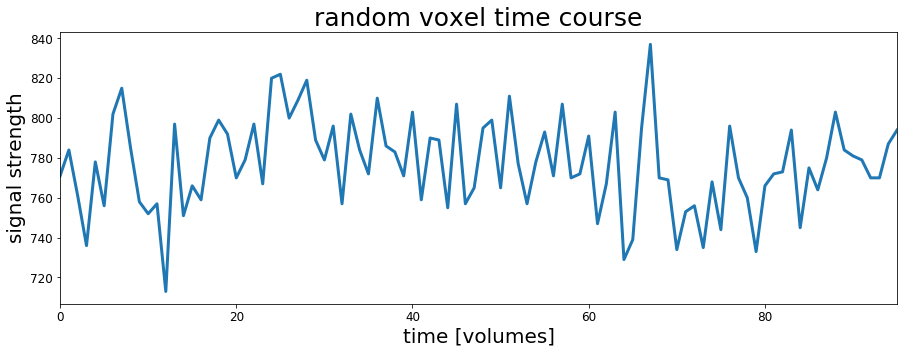

In [10]:
# Select a random voxel by getting one random x- and y-coorinate
x_voxel = np.random.randint(64)
y_voxel = np.random.randint(64)

# Create the plot
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(data_ordered[x_voxel, y_voxel], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('random voxel time course', fontsize=25)
ax.tick_params(labelsize=12)
plt.show()

Assuming the signal is at baseline level and during stimulation goes up, we must create a "design matrix" to represent the hypothesis. The design matrix also contains a constant part which we will need to create our general linear model.

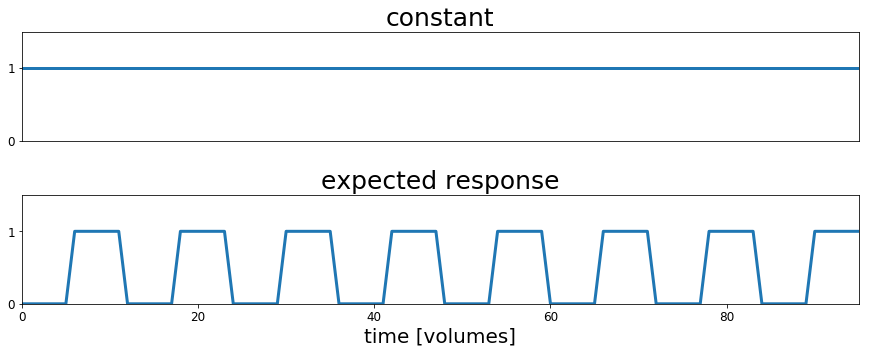

In [11]:
# Create the design matrix
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

# Create the plots
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [volumes]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Looking for a voxel that has a similar timecourse, we utilize a simple correlation analysis.

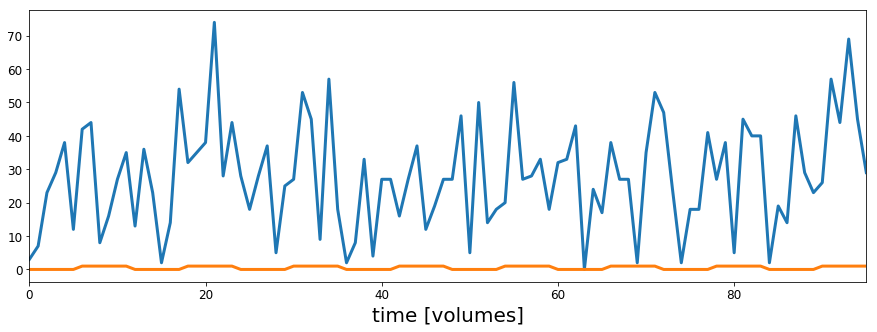

In [12]:
# Calculate the correlation coefficients
c = np.corrcoef(design_matrix[1,:], data)[1:,0]

# Find the voxel with the highest correlation coefficient
strongest_correlated = data[c.argmax(),:]

# Create the plots
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(strongest_correlated, lw=3)
ax.plot(design_matrix[1,:], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
plt.show()

From above, you can see a huge offset in the data. Normalizing the data so we can visualize it better, we utilize min-max-scaling

In [14]:
# Define the min-max scaling function
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

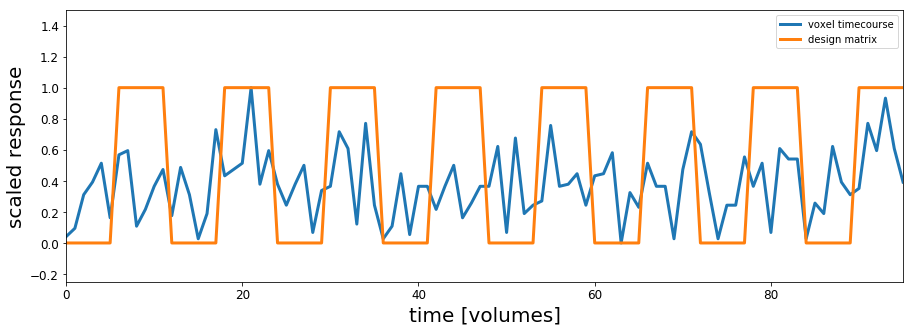

In [15]:
# Scale the voxel with the highest correlation
strongest_correlated_scaled = scale(data[c.argmax(),:])

# Create the plots
fig, (ax) = plt.subplots(1,1,figsize=(15, 5))
ax.plot(strongest_correlated_scaled, label='voxel timecourse', lw=3)
ax.plot(design_matrix[1,:], label='design matrix', lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(-0.25, 1.5)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('scaled response', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()
plt.show()

To check voxels that correlate with the idealized timecourse distributed across the brain, we reshape the correlation vector to a 64x64 matrix to match the mean signal map we created. Then, we select a treshold so that we only see voxels that have a correlation coefficient higher than 0.1 (totally arbitrary and up to you)

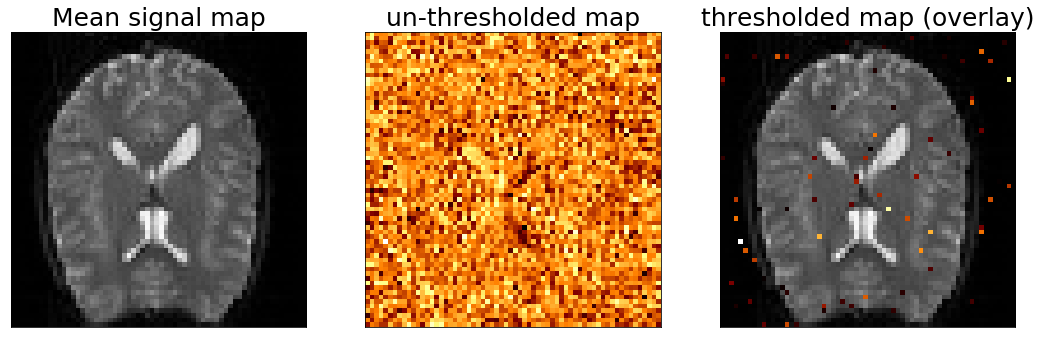

In [16]:
corr = c.reshape(x_size, y_size)
map = corr.copy()
map[map < 0.2] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('Mean signal map', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(corr,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

As we can see from the un-thresholded map the voxels with high correlations are not randomly distributed across the map but actually form a bigger cluster on the right side and a smaller cluster on the left side of the map. Finally we can see from the overlay that both clusters are located within the brain. The region were they are located is actually the auditory cortex which - as you may have guessed - is involved in processing auditory information.